# Colab Login stuff

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Global Params: Only this needs to be changed

In [0]:
num_train = 5000
num_calib = 750
num_test = 500

k = 75

# num_train = 100
# num_calib = 10
# num_test = 10
# k = 3

# path = 'gdrive/My Drive/Colab Notebooks/P3/Work/'

path = 'gdrive/My Drive/Colab Notebooks/P3/ThisOne/'

# Imorting Libraries

In [0]:
import time 
import keras
import numpy as np 
import pandas as pd

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

os.environ[ "CUDA_VISIBLE_DEVICES" ]="1"

import pandas as pd

from IPython.display import display, HTML

from numpy import argmax

# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from random import randint

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import make_classification

# Set random seed
np.random.seed(0)

In [0]:
from keras.layers import Activation, Flatten
from keras.layers import Convolution2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras import optimizers

In [0]:
from keras.models import load_model

In [0]:
from collections import Counter

In [0]:
from keras import backend as K
from timeit import default_timer as timer

In [0]:
import warnings
import sklearn
from sklearn.neighbors import LSHForest

In [0]:
!pip install cleverhans

    100% |████████████████████████████████| 204kB 23.3MB/s 
    100% |████████████████████████████████| 51kB 15.9MB/s 


In [0]:
import tensorflow as tf

from keras import backend
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import MomentumIterativeMethod

# Full MNIST Dataset

In [0]:
def get_data(verbose = False):

  # Set random seed
  np.random.seed(0)

  (x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
  if verbose == True: 
    print("Direct MNIST data: ")
    print('x_train_full.shape = {},  y_train_full.shape = {}'.format(x_train_full.shape, y_train_full.shape))
    print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
    print("_____________________________________________________________________________")

  # Reshaping X and y

  im_size = 784 # 28 x 28
  # building the input vector from the 28x28 pixels
  x_train_full = x_train_full.reshape(x_train_full.shape[0], 28, 28,1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
  x_train_full = x_train_full.astype('float16')
  x_test = x_test.astype('float16')

  # normalizing the data to help with the training
  x_train_full /= 255
  x_test /= 255

  # Convert class vectors to binary class matrices with one-hot encoding
  num_classes = 10
  y_train_full = keras.utils.to_categorical(y_train_full, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  if verbose == True:
    print("Reshaped Data:")
    print('x_train_full.shape = {},  y_train_full.shape = {}'.format(x_train_full.shape, y_train_full.shape))
    print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
    print("_____________________________________________________________________________")
  ############################################################################################

  # Callibration data for DKNN

  x_calib = x_train_full[50000:]
  y_calib = y_train_full[50000:]

  x_train = x_train_full[:50000]
  y_train = y_train_full[:50000]


  if verbose == True:
    print("With the train, test, calibration split: ")
    print("x_train_full = x_train + x_calib")
    print("y_train_full = y_train + y_calib")
    print("\n")
    print("Data required for DKNN:")
    print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
    print('x_calib.shape = {},  y_calib.shape = {}'.format(x_calib.shape, y_calib.shape))
    print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
    print("_____________________________________________________________________________")

  return ((x_train, y_train),(x_test, y_test),(x_calib,y_calib))

In [0]:
(x_train_full, y_train_full),(x_test, y_test),(x_calib,y_calib) = get_data(verbose = True)

11493376/11490434 [==============================] - 1s 0us/step
Direct MNIST data: 
x_train_full.shape = (60000, 28, 28),  y_train_full.shape = (60000,)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000,)
_____________________________________________________________________________
Reshaped Data:
x_train_full.shape = (60000, 28, 28, 1),  y_train_full.shape = (60000, 10)
x_test.shape = (10000, 28, 28, 1),  y_test.shape = (10000, 10)
_____________________________________________________________________________
With the train, test, calibration split: 
x_train_full = x_train + x_calib
y_train_full = y_train + y_calib


Data required for DKNN:
x_train.shape = (50000, 28, 28, 1),  y_train.shape = (50000, 10)
x_calib.shape = (10000, 28, 28, 1),  y_calib.shape = (10000, 10)
x_test.shape = (10000, 28, 28, 1),  y_test.shape = (10000, 10)
_____________________________________________________________________________


In [0]:
orig = np.where(y_train_full)[1]
res = Counter(orig)
print(res)

Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})


In [0]:
orig = np.where(y_test)[1]
res = Counter(orig)
print(res)

Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [0]:
orig = np.where(y_test[8000:])[1]
res = Counter(orig)
print(res)

Counter({1: 230, 7: 215, 0: 207, 3: 207, 6: 202, 2: 198, 4: 194, 9: 191, 8: 187, 5: 169})


# Small datasets for easy development

In [0]:
def get_small_data(num_train, num_calib, num_test, verbose = False):
  """
  num_train, : int, between 0 and 60k 
  num_calib, num_test : int, between 0 and 10k
  
  returns: train, calib, test data with num_train, num_calib and num_test samples
  """
  
  (x_train, y_train),(x_test, y_test),(x_calib, y_calib) = get_data()
  
  ### Train data
  x_train = x_train[0:num_train]
  y_train = y_train[0:num_train]
  
  # Small Calibration Data
  x_calib = x_calib[0:num_calib]
  y_calib = y_calib[0:num_calib]
  
  # Small Testing Data
  x_test = x_test[0:num_test]
  y_test = y_test[0:num_test]
  
  if verbose == True:
    
    print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
    orig = np.where(y_train)[1]
    res = Counter(orig)
    print("Train Distribution:", res)
    print("____________________________________________________________________________________________________________")
    
    print('x_calib.shape = {},  y_calib.shape = {}'.format(x_calib.shape, y_calib.shape))
    orig = np.where(y_calib)[1]
    res = Counter(orig)
    print("Calib Distribution:", res)
    print("____________________________________________________________________________________________________________")
    
    print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
    orig = np.where(y_test)[1]
    res = Counter(orig)
    print("Train Distribution:", res)
    print("____________________________________________________________________________________________________________")

    
  return ((x_train, y_train),(x_test, y_test),(x_calib,y_calib))

In [0]:
(x_train, y_train),(x_test, y_test),(x_calib, y_calib) = get_small_data(num_train, num_calib, num_test, verbose = True)

x_train.shape = (5000, 28, 28, 1),  y_train.shape = (5000, 10)
Train Distribution: Counter({1: 563, 7: 550, 4: 535, 6: 501, 9: 495, 3: 493, 2: 488, 0: 479, 8: 462, 5: 434})
____________________________________________________________________________________________________________
x_calib.shape = (750, 28, 28, 1),  y_calib.shape = (750, 10)
Calib Distribution: Counter({8: 86, 1: 79, 3: 77, 0: 77, 6: 76, 7: 74, 9: 73, 4: 70, 2: 70, 5: 68})
____________________________________________________________________________________________________________
x_test.shape = (500, 28, 28, 1),  y_test.shape = (500, 10)
Train Distribution: Counter({1: 67, 2: 55, 4: 55, 9: 54, 5: 50, 7: 49, 3: 45, 6: 43, 0: 42, 8: 40})
____________________________________________________________________________________________________________


# DNN Model from Papernot Paper

In [0]:
CUSTOM_OUTPUT_CATEGORIES = 10
IMAGE_RESCALE_SIZE = 28


BATCH_SIZE = 128

CUSTOM_TENSORBOARD = keras.callbacks.TensorBoard(
                                                    log_dir='/tmp/deepknn',
                                                    histogram_freq=10,
                                                    batch_size=BATCH_SIZE,
                                                    write_graph=True,
                                                    write_grads=True    )

In [0]:
def DeepNet2():
    # uses theano ordering. Note that we leave the image size as None to allow multiple image sizes
    num_classes = 10
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(8, 8), strides = (2,2), padding = 'same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(128, kernel_size=(6, 6),  strides = (2,2), padding = 'valid', activation='relu'))
    model.add(Conv2D(128, kernel_size=(5, 5),  strides = (1,1), padding = 'valid',  activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer= adam,
                  metrics=['accuracy'])
    CUSTOM_TENSORBOARD.set_model(model)
    return model

## Training the DNN Model

In [0]:
# model = DeepNet2()
# model_history = model.fit(x_train_full, y_train_full, validation_split=0.2, epochs=10, batch_size=128)

In [0]:
# model.save(path+'deepKNN_model_2.h5')  # creates a HDF5 file 
# del model 

In [0]:
keras.backend.set_learning_phase(False)

# returns a compiled model
model = load_model(path+'deepKNN_model_2.h5')

In [0]:
model.layers

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 710,218
Trainable params: 710,218
Non-trainable params: 0
_________________________________________________________________


## Testing the DNN Model

In [0]:
res = model.evaluate(x_test,y_test, verbose=1) 

500/500 [==============================] - 0s 874us/step


In [0]:
print("Accuracy of the DeepNet2() model from Papernot paper is: ", res[1])

Accuracy of the DeepNet2() model from Papernot paper is:  0.988


## DNN Predictions

In [0]:
y_dnn_pred = model.predict(x_test)

# Deep KNN Implemntation Necessities

## Layer outputs

### Function to Get One Layer Outputs

In [0]:
def getOneLayerOutput(data, layer, verbose = False):
  """
  data: x_train/x_calib/x_test
  
  layer: int, 0,1,2,3,4,5 => ex: model.layers[0]
  
  return: reshaped layerOutput 
  """
  start = timer()
  
  ###################################################################################################################
  _inputLayer = model.layers[0].input 
  _requiredLayer = model.layers[layer].output
  
  get_layer_output = K.function([_inputLayer], [_requiredLayer])
  
  layerOutput = get_layer_output([data])[0]
    
  if layer <= 2:
    numDataPoints = layerOutput.shape[0]
    b = layerOutput.shape[1]
    c = layerOutput.shape[2]
    d = layerOutput.shape[3]
    layerOutput = layerOutput.reshape(numDataPoints, b*c*d )
    
#   else if layer >=3 : # No reshape required
#     pass
  ###################################################################################################################
  
  end = timer()
  
  if verbose == True:
    print("Time taken to get layer num ", layer," output: ",round(end - start,4)," seconds") # Time in seconds, e.g. 5.38091952400282
  
  return layerOutput

### Function to Get All Layer Outputs

In [0]:
def allLayerOutputs(data, neuralModel, verbose = False):
  allLayerOutputs = []
    
  for layerNum in range(len(neuralModel.layers)):
    allLayerOutputs.append(getOneLayerOutput(data, layerNum, verbose))
  
  if verbose == True:
    print("Number of Layer Outputs:",len(allLayerOutputs))
    print("______________________________________________________________________________________________")
  return allLayerOutputs


### Geting Layer Outputs for x_train, x_test, x_calib

In [0]:
trainAllLayerOutputs = allLayerOutputs(x_train, model, verbose = True)

testAllLayerOutputs = allLayerOutputs(x_test, model, verbose = True)

calibAllLayerOutputs = allLayerOutputs(x_calib, model, verbose = True)

Time taken to get layer num  0  output:  0.9884  seconds
Time taken to get layer num  1  output:  2.2156  seconds
Time taken to get layer num  2  output:  2.0863  seconds
Time taken to get layer num  3  output:  2.0366  seconds
Time taken to get layer num  4  output:  2.0145  seconds
Number of Layer Outputs: 5
______________________________________________________________________________________________
Time taken to get layer num  0  output:  0.0777  seconds
Time taken to get layer num  1  output:  0.2023  seconds
Time taken to get layer num  2  output:  0.2204  seconds
Time taken to get layer num  3  output:  0.2199  seconds
Time taken to get layer num  4  output:  0.2133  seconds
Number of Layer Outputs: 5
______________________________________________________________________________________________
Time taken to get layer num  0  output:  0.1096  seconds
Time taken to get layer num  1  output:  0.3136  seconds
Time taken to get layer num  2  output:  0.3207  seconds
Time taken to g

## Getting Closest Labels


### Function to Get Closest Labels at ONE Layer for one test input

In [0]:
# Ignoring warnings as we do not need the knn classifier to be accurate. We need collisions for DeepKNN to work
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.DataDimensionalityWarning)

def closest_labels_oneInput_oneLayer_LSHForest(trainLayerOutputs, testInput, k = 3):
  """
  trainLayerOutputs: List, reshaped layer outputs of ONE layer lambda
  
  testInput: np array, dimension = reshaped layer output size
  
  k: int, number of neighbors required
  
  return: list, labels of "k" closest neighbors at one layer
  """

  
  closest_x_at_one_layer=[]

  lshf = LSHForest(random_state=42)
  lshf.fit(trainLayerOutputs)  
  
#   print("First k = ", k, " Neigbours are:")
  
  # finding k neighbours in training data closest to test example
  distances, indices = lshf.kneighbors([testInput], n_neighbors= k)

  # Data points in trainLayerOutputs matching testInput 
#   print(indices) 
  
  omega_labels_at_one_layer = []
  for index in indices[0]:
#     print("This thing")
    queryLoc_InTrainData = index
    oneHot = y_train[queryLoc_InTrainData]
    y = argmax(oneHot)
    omega_labels_at_one_layer.append(y)

#   print("Labels in current layer are:")
#   print(omega_labels_at_one_layer)

  return omega_labels_at_one_layer

### Function to get Closest Labels at ALL Layers for one test input

In [0]:
def closest_labels_oneInput_allLayers(trainLayerOutputs, totalLayers ,testInput, whichMethod, k = 3):
  """
  trainLayerOutputs: List, reshaped layer outputs of ONE layer lambda
  
  totalLayers: int, total number of layers ==> 6 
  
  whichMethod: "LSHOrig" or "LSHForest"
  
  testInput: np array, dimension = reshaped layer output size
  
  k: int, number of neighbors required
  
  return: list of list of labels of "k" closest neighbors at one layer ==> 2 layers, k=3: [[3,3,3],[3,3,3]]
  """
  
  closestLabelsAtAllLayers = []
  
  if whichMethod == "LSHForest":
    closest_labels_oneInput_oneLayer = closest_labels_oneInput_oneLayer_LSHForest
  elif whichMethod == "LSHOrig":
    closest_labels_oneInput_oneLayer = closest_labels_oneInput_oneLayer_LSHOrig
  
  for layer in range(totalLayers):
    closestAtOneLayer = closest_labels_oneInput_oneLayer(trainLayerOutputs[layer], testInput[layer], k = k)
    closestLabelsAtAllLayers.append(  closestAtOneLayer   )
    
  return closestLabelsAtAllLayers

#### Example code for function closest_labels_oneInput_allLayers(* args *)

In [0]:
test_input_z = []

for layer in range(len(model.layers)):
  layer_output = calibAllLayerOutputs[layer][0]
  test_input_z.append(layer_output)

totalLayers = len(model.layers)
testInput = test_input_z
expectedLabel = y_calib[0]
whichMethod = "LSHForest"

# k = 75

start = timer()

closestAtAllLayers = closest_labels_oneInput_allLayers(trainAllLayerOutputs, totalLayers, testInput, whichMethod, k = 3)
end = timer()


In [0]:
print("Time taken to find k neighbors at all layers for 1 output: ",round(end - start,4)," seconds") # Time in seconds, e.g. 5.38091952400282
print("Closest neighbours at layers [0,1,2,3,4,5] are:")
print(closestAtAllLayers)
print("Expected label is:", argmax(expectedLabel))

Time taken to find k neighbors at all layers for 1 output:  6.8054  seconds
Closest neighbours at layers [0,1,2,3,4,5] are:
[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Expected label is: 3


### Getting Closest Labels at ALL Layers for ALL test input

#### Reorganization wrt Examples

Data like *calibAllLayerOutputs* till here was orgainized wrt layers. 

Organizing here wrt Examples.

In [0]:
# print("Number of Layer Outputs(same as number of layers):")
# print(len(calibAllLayerOutputs))

# print("\n")

# layer = 3
# print("Number of data points at layer",layer, " are:" )
# print(len(calibAllLayerOutputs[layer]))

In [0]:
def reorganize_wrt_examples(data, layers):
  """
  data: calibAllLayerOutputs, testAllLayerOutputs <= these are orgainized wrt layers: [layer1[1000 examples], layer2[1000 examples], ..., layer6[1000 examples]]
  
  layers: number of layers
  
  return: all_test_inputs_at_all_layers <= this is organized wrt examples: [Example1[6 layers], example2[6 layers],...example1000[6layers]]
  """
  

  all_test_inputs_at_all_layers = []

  for anInput in range(len(data[1])):

    One_test_input_at_all_layers = []

    for layer in range(layers):

      layer_output = data[layer][anInput]
      One_test_input_at_all_layers.append(layer_output)

    all_test_inputs_at_all_layers.append(  One_test_input_at_all_layers  )
    
  return all_test_inputs_at_all_layers

##### Example reorganization

In [0]:
totalLayers = len(model.layers)

data = calibAllLayerOutputs

allTestInputs = reorganize_wrt_examples(data, totalLayers)
testInput = allTestInputs[0]

expectedLabel = y_calib[0]

# k = 75

start = timer()

closestAtAllLayers = closest_labels_oneInput_allLayers(trainAllLayerOutputs, totalLayers, testInput, whichMethod = "LSHForest", k = 3)
end = timer()

In [0]:
print("Time taken to find k neighbors at all layers for 1 output: ",round(end - start,4)," seconds") 
print("Closest neighbours at layers [[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors]] are:")
print(closestAtAllLayers)
print("Expected label is:", argmax(expectedLabel))

Time taken to find k neighbors at all layers for 1 output:  6.6518  seconds
Closest neighbours at layers [[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors]] are:
[[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Expected label is: 3


#### Function to get Closest neighbors for all inputs at all test layers using the reorganization

In [0]:
def closest_labels_allInputs_allLayers(trainLayerOutputs, totalLayers, allTestInputs, whichMethod, k = 3):
  """
  trainLayerOutputs: List, reshaped layer outputs of ONE layer lambda
  
  totalLayers: int, total number of layers ==> 6 
  
  allTestInputs: np array, dimension = (num test data points,   reshaped layer output size)
  
  whichMethod: "LSHOrig" or "LSHForest"
  
  k: int, number of neighbors required
  
  return: list of list of list of labels of "k" closest neighbors at one layer ==> 2 example points with expected labels [3,4] ,2 layers, k=3: [  [[3,3,3],[3,3,3]],  [[4,4,4],[4,4,4]]
  """
  
  closestNeighbors_ForAllInputs = []
  for oneInput in allTestInputs:
    closestNeighbors_ForEachInput = closest_labels_oneInput_allLayers(trainLayerOutputs, totalLayers, oneInput, whichMethod, k = k)
    closestNeighbors_ForAllInputs.append(   closestNeighbors_ForEachInput    ) 
    
  return closestNeighbors_ForAllInputs 

##### closest_labels_allInputs_allLayers( *Calibration Data*  )  

In [0]:
# totalLayers = len(model.layers)

# data = calibAllLayerOutputs
# allTestInputs = reorganize_wrt_examples(data, totalLayers)

# expectedLabels = y_calib

# # k = 75

# start = timer()
# closestNeighbors_ForAllCalibInputs = closest_labels_allInputs_allLayers(trainAllLayerOutputs, totalLayers, allTestInputs, whichMethod = "LSHForest",k = k)
# end = timer()

In [0]:
# print("Time taken to find k neighbors at all layers for all calib inputs: ",round((end - start)/60 , 4)," minutes") # Time in seconds, e.g. 5.38091952400282
# print("Closest neighbours at layers:")
# print("\n")
# print("[[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors],...[Layer(Lambda) neighbors] ] are:")
# print(closestNeighbors_ForAllCalibInputs[0])
# print("Expected label is:", argmax(expectedLabels[0]))

###### Storing Stuff using Pickle

In [0]:
# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]

# Saving the objects:
# with open(path+'ClosestNeighborsFor'+ str(num_calib) +'CALIBpoints.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([closestNeighbors_ForAllCalibInputs, expectedLabelsArgMax], f)


# Getting back the objects:
with open(path+'ClosestNeighborsFor'+ str(num_calib) +'CALIBpoints.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     closestNeighbors_ForAllCalibInputs, expectedLabelsArgMax = pickle.load(f)

In [0]:
print(closestNeighbors_ForAllCalibInputs[0])

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 5, 3, 8, 3, 8, 3, 3, 3, 3, 2, 8, 8, 9, 2, 3, 8, 5], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 5, 3, 2, 8, 2, 3, 8, 8, 2, 2, 5, 8, 2, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

###### Displaying closest neighbors at all layers using Pandas

In [0]:
data_dict = {"All Layer Outputs": closestNeighbors_ForAllCalibInputs, "Expected Labels": expectedLabelsArgMax}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,All Layer Outputs,Expected Labels
0,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 5, 3, 8, 3, 8, 3, 3, 3, 3, 2, 8, 8, 9, 2, 3, 8, 5], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 5, 3, 2, 8, 2, 3, 8, 8, 2, 2, 5, 8, 2, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]",3
1,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 2, 8, 2, 8, 8, 3, 3, 8, 8, 8, 9, 3, 2, 8, 5, 8, 8, 2, 8, 8, 5, 8, 5, 8, 8, 4, 8, 9, 8, 8, 3, 4, 4, 8, 8, 9, 3, 4, 9, 4, 4, 1, 5, 1, 8, 1, 3, 4, 9, 1, 5, 3, 4, 1, 1, 1], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 5, 5, 3, 2, 8, 8, 5, 2, 8, 8, 3, 5, 8, 3, 8, 8, 3, 2, 8, 5, 3, 3, 8, 8, 9, 3, 3, 3, 3, 5, 8, 3], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]",8
2,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 0, 6], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]]",6
3,"[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 4, 9, 4, 9, 9, 7, 9, 4, 4, 9, 4, 9, 4, 7, 9, 9, 7, 9, 4, 7, 9, 4, 9, 4, 7, 9, 4, 8, 4, 4, 9, 4, 8, 4, 9, 7, 9, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 5, 7, 7, 7, 3, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 7, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 9, 7, 9, 9, 7, 4, 7, 9, 7, 5, 7, 7, 4, 7, 7, 7, 7, 7, 9, 7, 7, 3, 7, 7, 9, 4, 9, 9, 9, 7, 7, 7, 4, 7, 7, 7, 7, 9, 7, 7, 3, 7], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [0]:
# Read a stored data frame

# path = 'gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv'

# data = pd.read_csv(path) 

##### closest_labels_allInputs_allLayers( *Test Data*  )  

In [0]:
# totalLayers = len(model.layers)

# data = testAllLayerOutputs
# allTestInputs = reorganize_wrt_examples(data, totalLayers)

# expectedLabels = y_test

# # k = 75

# start = timer()
# closestNeighbors_ForAllTestInputs = closest_labels_allInputs_allLayers(trainAllLayerOutputs, totalLayers, allTestInputs, whichMethod = "LSHForest",k = k)
# end = timer()

In [0]:
# print("Time taken to find k neighbors at all layers for all test points: ",round((end - start)/60 , 4)," minutes") # Time in seconds, e.g. 5.38091952400282
# print("Closest neighbours at layers [[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors],...[Layer(Lambda) neighbors] ] are:")
# print(closestNeighbors_ForAllTestInputs[1])
# print("Expected label is:", argmax(expectedLabels[1]))

###### Storing Stuff using Pickle

In [0]:
# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]

# # Saving the objects:
# with open(path+'ClosestNeighborsFor'+ str(num_test) +'TESTpoints.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([closestNeighbors_ForAllTestInputs, expectedLabelsArgMax], f)

# Getting back the objects:
with open(path+'ClosestNeighborsFor'+ str(num_test) +'TESTpoints.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     closestNeighbors_ForAllTestInputs, expectedLabelsArgMax = pickle.load(f)

In [0]:
print(closestNeighbors_ForAllTestInputs[0])

[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 9, 9, 9, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

###### Displaying closest neighbors using Pandas

In [0]:
  data_dict = {"All Layer Outputs": closestNeighbors_ForAllTestInputs, "Expected Labels": expectedLabelsArgMax}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,All Layer Outputs,Expected Labels
0,"[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 9, 9, 9, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]]",0
1,"[[2, 2, 2, 2, 1, 2, 3, 2, 2, 8, 3, 3, 3, 3, 3, 2, 0, 3, 2, 2, 3, 3, 2, 3, 3, 8, 3, 2, 3, 3, 3, 3, 3, 3, 2, 0, 2, 2, 2, 3, 3, 6, 2, 3, 0, 2, 8, 6, 3, 0, 2, 3, 3, 6, 6, 6, 5, 2, 3, 3, 6, 2, 8, 3, 0, 3, 6, 2, 3, 2, 3, 5, 0, 0, 0], [2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 8, 2, 6, 2, 2, 2, 3, 5, 3, 2, 6, 3, 3, 3, 2, 0, 0, 0, 3, 6, 3, 0, 0, 2, 9, 3, 5, 3, 5, 3, 0, 6, 5, 3, 5, 6, 8, 6, 1, 0, 2, 3, 6, 3, 1, 2, 3, 0, 3, 2, 5, 5, 3, 1, 6, 2, 0, 6, 2, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 8, 8, 2, 2, 2, 6, 2, 8, 2, 6, 8, 8, 0, 0, 6, 8, 6, 2, 8, 8, 3, 1, 1, 6, 1, 1, 3, 6], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 8, 8, 2, 2, 2, 6, 2, 8, 2, 6, 8, 8, 0, 0, 6, 8, 6, 2, 8, 8, 3, 1, 1, 6, 1, 1, 3, 6], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]",0
2,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# data = pd.read_csv(path) 

## Changing the naming to match the paper

In [0]:
omega_lambda = closestNeighbors_ForAllCalibInputs[:]

In [0]:
# k = 75 neighbor points at 5 layers for numCalib number of data points
print(omega_lambda)
print(len(omega_lambda[0]))
print((omega_lambda[0]))

[[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 5, 3, 8, 3, 8, 3, 3, 3, 3, 2, 8, 8, 9, 2, 3, 8, 5], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 5, 3, 2, 8, 2, 3, 8, 8, 2, 2, 5, 8, 2, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [0]:
# k=3 neighbor points at lambda number of layers
print((omega_lambda[0]))

# k = 3 neighbor points
print((omega_lambda[0][0]))

# One neighbor point
print((omega_lambda[0][0][0]))

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 5, 3, 8, 3, 8, 3, 3, 3, 3, 2, 8, 8, 9, 2, 3, 8, 5], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 5, 3, 2, 8, 2, 3, 8, 8, 2, 2, 5, 8, 2, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

## Get set A for each data point in calibration data (ie non conformity for x_calib)

### Get A

In [0]:
def get_A(x_calib, y_calib, numModelLayers, omega_lambda):
  """
  x_calib, y_calib: calibration images and corresp. labels
  
  numModelLayers: number of layers in the DL model
  
  omega_lambda: lambda reps for each of 6 layers
                list, conatains labels of nearest neighbors at each layer lambda
  """
  
  A = []
  
#   for oneExample in omega_lambda: 
  
  for Index in range(len(y_calib)):

    y = np.argmax(y_calib[Index])
    oneTestPointAtLambdaNumLayers = omega_lambda[Index]
    
    alpha = 0
    for lam in range(numModelLayers):
      
      oneTestPointAtONELayer = oneTestPointAtLambdaNumLayers[ lam  ]
    
      for oneNeighborLabel in oneTestPointAtONELayer:

        if oneNeighborLabel != y:
          alpha += 1

      A.append(alpha)
    
  return A



In [0]:
numModelLayers = len(model.layers)

A = get_A(x_calib, y_calib, numModelLayers, omega_lambda)

print(A)

[15, 30, 30, 30, 30, 37, 61, 61, 61, 61, 4, 7, 7, 7, 7, 41, 78, 79, 80, 80, 43, 77, 79, 81, 81, 54, 102, 127, 152, 152, 50, 113, 130, 147, 147, 40, 91, 93, 95, 95, 40, 55, 55, 55, 55, 39, 76, 76, 76, 76, 63, 105, 107, 109, 109, 23, 29, 29, 29, 29, 31, 49, 49, 49, 49, 42, 75, 75, 75, 75, 47, 71, 72, 73, 73, 35, 75, 77, 79, 79, 37, 61, 61, 61, 61, 48, 91, 102, 113, 113, 38, 38, 38, 38, 38, 34, 66, 68, 70, 70, 25, 68, 71, 74, 74, 17, 26, 28, 30, 30, 43, 68, 68, 68, 68, 30, 36, 36, 36, 36, 31, 62, 83, 104, 104, 55, 101, 123, 145, 145, 41, 65, 65, 65, 65, 16, 49, 49, 49, 49, 42, 60, 60, 60, 60, 39, 77, 88, 99, 99, 42, 77, 77, 77, 77, 23, 52, 52, 52, 52, 9, 9, 9, 9, 9, 31, 93, 97, 101, 101, 15, 44, 44, 44, 44, 27, 63, 63, 63, 63, 5, 18, 18, 18, 18, 45, 66, 66, 66, 66, 22, 31, 31, 31, 31, 7, 33, 33, 33, 33, 60, 91, 99, 107, 107, 56, 95, 96, 97, 97, 22, 57, 57, 57, 57, 43, 75, 75, 75, 75, 40, 83, 84, 85, 85, 25, 55, 55, 55, 55, 57, 62, 73, 84, 84, 15, 26, 26, 26, 26, 45, 62, 70, 78, 78, 41, 70

In [0]:
# Must be equal

print(num_calib * len(model.layers))

print(len(A))

3750
3750


## Deep KNN Metrics: Prediction, Credibility, Confidence

In [0]:
import numpy as np
from numpy import argmax
def metrics(closest_labels_found, A):
    
    alpha_z_j = []
    alpha_z_j_2 = []
    p_j_z = []
    p_j_z_2 = []
    prediction = []
    credibility = []
    confidence = []
    
    for z in range(len(closest_labels_found)):
        a = np.array(closest_labels_found[z])
        b = a.reshape(a.shape[0]*a.shape[1])
        #print(b)
        alpha_z_j = []
        p_j_z = []
        for label in range(10):     
            c = np.full((a.shape[0]*a.shape[1]), label)
            d = (b != c).sum()          #non_conformity
            alpha_z_j.append(d)         

            #number of values in A which are greater than alpha_z_j- whichh is d here
            e =  np.full((len(A)), d)    
            f = (A >= d).sum()
            g = f*(1/len(A))
            p_j_z.append(g)

        prediction.append(argmax(p_j_z))
        credibility.append(max(p_j_z))
        
        h = p_j_z[:]
        del h[argmax(h)]   
        confidence.append(1 - max(h)) 
        
        #To get something similar to ouput probabilities
#         maximum = max(p_j_z)
#         p_j_z =  [i/maximum for i in p_j_z]
        
        alpha_z_j_2.append(alpha_z_j)   ###for other find this
        p_j_z_2.append(p_j_z)
        
    return(prediction, credibility, confidence, p_j_z_2)

# Evaluation of Metrics on Calibration Data

In [0]:
# closestNeighbors_ForAllCalibInputs is obtained wrt the calibration data
start = timer()
predCalib,credCalib,confCalib, outputProbCalib = metrics(closestNeighbors_ForAllCalibInputs, A)
end = timer()

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Time taken = ", round(end-start, 4), "seconds")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

# for i in range(len(y_calib)):
#   y = np.argmax(y_calib[i])
#   print("True Label = ", y)
#   print("Prediction = ", predCalib[i])
#   print("Confidence = ", confCalib[i])
#   print("Credibility = ", credCalib[i])
#   print("______________________________________________________________________")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time taken =  1.9878 seconds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [0]:
for j in range(5):
  print(sum(outputProbCalib[j]))
  print(sum(y_calib[j]))
  print("___________________________________________________________________________________________________________________")

0.7002666666666667
1.0
___________________________________________________________________________________________________________________
0.3997333333333334
1.0
___________________________________________________________________________________________________________________
0.8754666666666667
1.0
___________________________________________________________________________________________________________________
0.2650666666666667
1.0
___________________________________________________________________________________________________________________
0.25920000000000004
1.0
___________________________________________________________________________________________________________________


#### Displaying stuff using Pandas

In [0]:
expectedLabelsArgMax = [argmax(i) for i in y_calib]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"True Label": expectedLabelsArgMax, "DkNN Prediction": predCalib, "Confidence": confCalib, "Credibility": credCalib}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,Confidence,Credibility,DkNN Prediction,True Label
0,0.999200,0.698667,3,3
1,0.998933,0.397333,8,8
2,1.000000,0.875467,6,6
3,0.998133,0.262133,9,9
4,0.998667,0.256267,6,6
5,0.997600,0.056267,4,4
6,0.997867,0.060533,5,5
7,0.998400,0.189867,3,3
8,0.998933,0.457333,8,8
9,0.998933,0.290667,4,4


In [0]:
# path = 'gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv'

# path = 'gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv'

# data = pd.read_csv(path) # Too much work. Storing using Pickle is easier

#### Accuracy on Calibration Data

In [0]:
accuracy = 0

for i in range(len(y_calib)):
  y = np.argmax(y_calib[i])
  
  if y-predCalib[i] == 0:
    accuracy += 1
    

accuracy = accuracy / len(y_calib)
print("Accuracy using Prediction from DKNN on x_calib = ", accuracy)

Accuracy using Prediction from DKNN on x_calib =  0.9693333333333334


In [0]:
neural = model.evaluate(x_calib,y_calib, verbose=1) # 98.98% accuracy

print("Accuracy using Prediction directly from DeepNet2() on x_calib = ", neural[1])

750/750 [==============================] - 0s 482us/step
Accuracy using Prediction directly from DeepNet2() on x_calib =  0.9733333333333334


In [0]:
def credibility_morethan_50(credList, predList, y_test, name ,verbose = 1):
  count = 0
  accuracy = 0
  for i in range(len(credList)):
    if credList[i] >= 0.5:
      count += 1
      if predList[i] == np.argmax(y_test[i]):
        accuracy += 1
  
  if verbose >= 1:
    print("Credibility above 50% for ",count," number of "+name+" samples out of ",num_test," number of total test samples.")  
    if verbose == 2:
      print("Accurate predictions for the credible samples is ", accuracy, "out of ",num_test," number of total test samples.")
      
  return (count, accuracy)

In [0]:
countCalib, credible_and_accurate_Calib = credibility_morethan_50(credCalib, predCalib, y_calib, "CALIB", verbose = 2)

Credibility above 50% for  321  number of CALIB samples out of  500  number of total test samples.
Accurate predictions for the credible samples is  319 out of  500  number of total test samples.


In [0]:
countCalib = 0
for credibility in credCalib:
  if credibility >= 0.5:
    countCalib += 1
    
print("Credibility above 50% for ",countCalib," number of Calib samples out of ",num_calib," number of total calib samples.")

Credibility above 50% for  321  number of Calib samples out of  750  number of total calib samples.


# Evaluation of Metrics on Test Data

In [0]:
# closestNeighbors_ForAllTestInputs is obtained wrt the test data
start = timer()
predTest,credTest,confTest, outputProbTest = metrics(closestNeighbors_ForAllTestInputs, A)
end = timer()

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Time taken = ", round(end-start, 4), "seconds")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

# for i in range(len(y_test)):
#   y = np.argmax(y_test[i])
#   print("True Label = ", y)
#   print("Prediction = ", predTest[i])
#   print("Confidence = ", confTest[i])
#   print("Credibility = ", credTest[i])
#   print("______________________________________________________________________")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time taken =  1.3047 seconds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [0]:
for j in range(5):
  print(sum(outputProbTest[j]))
  print(sum(y_test[j]))
  print("___________________________________________________________________________________________________________________")

1.0
1.0
___________________________________________________________________________________________________________________
1.1276595744680848
1.0
___________________________________________________________________________________________________________________
1.0
1.0
___________________________________________________________________________________________________________________
1.0
1.0
___________________________________________________________________________________________________________________
1.0032520325203251
1.0
___________________________________________________________________________________________________________________


#### Displaying stuff using Pandas

In [0]:
expectedLabelsArgMax = [argmax(i) for i in y_test]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"True Label": expectedLabelsArgMax, "DkNN Prediction": predTest, "Confidence": confTest, "Credibility": credTest}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,Confidence,Credibility,DkNN Prediction,True Label
0,1.000000,0.899467,7,7
1,0.998133,0.050133,2,2
2,1.000000,1.000000,1,1
3,1.000000,0.899467,0,0
4,0.998400,0.492000,4,4
5,1.000000,1.000000,1,1
6,0.997600,0.189867,4,4
7,0.998400,0.243733,9,9
8,0.998133,0.051733,5,5
9,0.998400,0.426133,9,9


In [0]:
# path = 'gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv'

# path = 'gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv'

# data = pd.read_csv(path) # Too much work. Storing using Pickle is easier

#### Accuracy on test data

In [0]:
accuracy = 0

for i in range(len(y_test)):
  y = np.argmax(y_test[i])
  
  if y-predTest[i] == 0:
    accuracy += 1
    

accuracy = accuracy / len(y_test)
print("Accuracy using Prediction from DKNN on x_test = ", accuracy)

Accuracy using Prediction from DKNN on x_test =  0.98


In [0]:
neural = model.evaluate(x_test,y_test, verbose=1) # 98.98% accuracy

print("Accuracy using Prediction directly from DeepNet2() on x_test = ", neural[1])

500/500 [==============================] - 0s 437us/step
Accuracy using Prediction directly from DeepNet2() on x_test =  0.988


In [0]:
countTest = 0
for credibility in credTest:
  if credibility >= 0.5:
    countTest += 1
    
print("Credibility above 50% for ",countTest," number of test samples out of ",num_test," number of total test samples.")

Credibility above 50% for  184  number of test samples out of  500  number of total test samples.


In [0]:
countTest, credible_and_accurate_Test = credibility_morethan_50(credTest, predTest, y_test, "TEST", verbose = 2)

Credibility above 50% for  184  number of TEST samples out of  500  number of total test samples.
Accurate predictions for the credible samples is  184 out of  500  number of total test samples.


# Evaluation of Deep KNN Metrics on Adversarial Data

## FGSM

### Generating FGSM data

In [0]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
# Retrieve the tensorflow session

sess =  backend.get_session()
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)

fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}

x_adv_FGSM = fgsm.generate_np(x_test, **fgsm_params)

[INFO 2019-02-02 17:50:06,519 cleverhans] Constructing new graph for attack FastGradientMethod


In [0]:
expectedLabels = [argmax(i) for i in y_test]

adv_pred = np.argmax(model.predict(x_adv_FGSM), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, expectedLabels))
print("The adversarial accuracy of just DeepNet2() for FGSM is: {}".format(adv_acc))

The adversarial accuracy of just DeepNet2() for FGSM is: 0.186


In [0]:
y_fgsm_pred = model.predict(x_adv_FGSM)

### Layer Outputs of DeepNet2() for FGSM data

In [0]:
FGSM_allLayerOutputs = allLayerOutputs(x_adv_FGSM, model, verbose = True)

Time taken to get layer num  0  output:  0.0859  seconds
Time taken to get layer num  1  output:  0.2118  seconds
Time taken to get layer num  2  output:  0.2188  seconds
Time taken to get layer num  3  output:  0.2233  seconds
Time taken to get layer num  4  output:  0.2313  seconds
Number of Layer Outputs: 5
______________________________________________________________________________________________


### Closest Neighbors For FGSM Data

#### Generating the Closest Neighbors

In [0]:
# totalLayers = len(model.layers)

# data = FGSM_allLayerOutputs
# allTestInputs = reorganize_wrt_examples(data, totalLayers)

# expectedLabels = y_test

# # k = 75

# start = timer()
# closestNeighbors_ForAllFGSMInputs = closest_labels_allInputs_allLayers(trainAllLayerOutputs, totalLayers, allTestInputs, whichMethod = "LSHForest",k = 75)
# end = timer()

In [0]:
# print("Time taken to find k neighbors at all layers for all FGSM points: ",round((end - start)/60 , 4)," minutes") # Time in seconds, e.g. 5.38091952400282
# print("Closest neighbours at layers [[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors],...[Layer(Lambda) neighbors] ] are:")
# print(closestNeighbors_ForAllFGSMInputs[1])
# print("Expected label is:", argmax(expectedLabels[1]))

#### Storing FGSM Neighbors using Pickle

In [0]:
# path = 'gdrive/My Drive/Colab Notebooks/P3/'
# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]

# # Saving the objects:
# with open(path+'ClosestNeighborsFor'+ str(num_test) +'FGSMpoints.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([closestNeighbors_ForAllFGSMInputs, expectedLabelsArgMax], f)

# Getting back the objects:
with open(path+'ClosestNeighborsFor'+ str(num_test) +'FGSMpoints.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     closestNeighbors_ForAllFGSMInputs, expectedLabelsArgMax = pickle.load(f)

In [0]:
print(closestNeighbors_ForAllFGSMInputs[0])

[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 9, 7, 9], [7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 7, 3, 7, 7, 2, 3, 9, 9, 9, 7, 7, 9, 7, 7, 7, 7, 9], [3, 7, 7, 7, 3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 7, 7, 7, 7, 3, 7, 3, 7, 7, 7, 7, 3, 3, 3, 3, 7, 7, 3, 7, 7, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 2, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2], [3, 7, 7, 7, 3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 7, 7, 7, 7, 3, 7, 3, 7, 7, 7, 7, 3, 3, 3, 3, 7, 7, 3, 7, 7, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 2, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

#### Displaying Neighbors for FGSM data using Pandas

In [0]:
import pandas as pd

# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"All Layer Outputs": closestNeighbors_ForAllFGSMInputs, "Expected Labels": expectedLabelsArgMax}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
# pd.set_option("display.max_colwidth", -1)
# frame

In [0]:
# data = pd.read_csv(path) # Too much work. Storing using Pickle is easier

#### Displaying prediction, confidence, credibility metrics using Pandas

In [0]:
# closestNeighbors_ForAllFGSMInputs is obtained wrt the x_adv_FGSM data
start = timer()
predFGSM,credFGSM,confFGSM,outputProbFGSM = metrics(closestNeighbors_ForAllFGSMInputs, A)
end = timer()

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Time taken = ", round(end-start, 4), "seconds")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

# # for i in range(len(y_calib)):
# #   y = np.argmax(y_calib[i])
# #   print("True Label = ", y)
# #   print("Prediction = ", predFGSM[i])
# #   print("Confidence = ", confFGSM[i])
# #   print("Credibility = ", credFGSM[i])
# #   print("______________________________________________________________________")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time taken =  1.2889 seconds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [0]:
for j in range(5):
  print(sum(outputProbFGSM[j]))
  print(sum(y_test[j]))
  print("___________________________________________________________________________________________________________________")

1.1003584229390682
1.0
___________________________________________________________________________________________________________________
1.0648464163822526
1.0
___________________________________________________________________________________________________________________
1.0574018126888216
1.0
___________________________________________________________________________________________________________________
1.064788732394366
1.0
___________________________________________________________________________________________________________________
1.0574018126888218
1.0
___________________________________________________________________________________________________________________


In [0]:
expectedLabelsArgMax = [argmax(i) for i in y_test]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"True Label": expectedLabelsArgMax, "DkNN Prediction": predFGSM, "Confidence": confFGSM, "Credibility": credFGSM}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,Confidence,Credibility,DkNN Prediction,True Label
0,0.993333,0.074400,7,7
1,0.997333,0.078133,2,2
2,0.997867,0.088267,1,1
3,0.994933,0.094667,0,0
4,0.996267,0.088267,9,4
5,0.975733,0.030933,4,1
6,0.997600,0.079467,9,4
7,0.997867,0.189867,4,9
8,0.997867,0.133067,6,5
9,0.997600,0.172533,4,9


In [0]:
# data = pd.read_csv(path) # Too much work. Storing using Pickle is easier

### Evaluation of FGSM data

In [0]:
accuracy = 0

for i in range(len(y_test)):
  y = np.argmax(y_test[i])
  
  if y-predFGSM[i] == 0:
    accuracy += 1
    

accuracy = accuracy / len(y_test)
print("Accuracy using Prediction from DKNN on x_adv_FGSM = ", accuracy)

Accuracy using Prediction from DKNN on x_adv_FGSM =  0.32


In [0]:
expectedLabels = [argmax(i) for i in y_test]

adv_pred = np.argmax(model.predict(x_adv_FGSM), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, expectedLabels))
print("The adversarial accuracy of just DeepNet2() on x_adv_FGSM = ",adv_acc)

The adversarial accuracy of just DeepNet2() on x_adv_FGSM =  0.186


In [0]:
countFGSM = 0
for credibility in credFGSM:
  if credibility >= 0.5:
    countFGSM += 1
    
print("Credibility above 50% for ",countFGSM," number of FGSM samples out of ",num_test," number of total test samples.")

Credibility above 50% for  31  number of FGSM samples out of  500  number of total test samples.


## BIM

### Generating BIM data

In [0]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
# Retrieve the tensorflow session

sess =  backend.get_session()
wrap = KerasModelWrapper(model)
bim = BasicIterativeMethod(wrap, sess=sess)

bim_params = {'eps': np.float32(0.3),
              'eps_iter': 0.03,
              'nb_iter': 10,
              'clip_min': 0.,
              'clip_max': 1.}

x_adv_BIM = bim.generate_np(x_test, **bim_params)

[INFO 2019-02-02 17:50:12,052 cleverhans] Constructing new graph for attack BasicIterativeMethod


In [0]:
expectedLabels = [argmax(i) for i in y_test]

adv_pred = np.argmax(model.predict(x_adv_BIM), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, expectedLabels))
print("The adversarial accuracy of just DeepNet2() for BIM is: {}".format(adv_acc))

The adversarial accuracy of just DeepNet2() for BIM is: 0.034


In [0]:
y_bim_pred = model.predict(x_adv_BIM)

### Layer Outputs of DeepNet2() for FGSM data

In [0]:
BIM_allLayerOutputs = allLayerOutputs(x_adv_BIM, model, verbose = True)

Time taken to get layer num  0  output:  0.0924  seconds
Time taken to get layer num  1  output:  0.2313  seconds
Time taken to get layer num  2  output:  0.2404  seconds
Time taken to get layer num  3  output:  0.2453  seconds
Time taken to get layer num  4  output:  0.2471  seconds
Number of Layer Outputs: 5
______________________________________________________________________________________________


### Closest Neighbors For BIM Data

#### Generating the Closest Neighbors

In [0]:
# totalLayers = len(model.layers)

# data = BIM_allLayerOutputs
# allTestInputs = reorganize_wrt_examples(data, totalLayers)

# expectedLabels = y_test

# # k = 75

# start = timer()
# closestNeighbors_ForAllBIMInputs = closest_labels_allInputs_allLayers(trainAllLayerOutputs, totalLayers, allTestInputs, whichMethod = "LSHForest",k = 75)
# end = timer()

In [0]:
# print("Time taken to find k neighbors at all layers for all BIM points: ",round((end - start)/60 , 4)," minutes") # Time in seconds, e.g. 5.38091952400282
# print("Closest neighbours at layers [[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors],...[Layer(Lambda) neighbors] ] are:")
# print(closestNeighbors_ForAllBIMInputs[1])
# print("Expected label is:", argmax(expectedLabels[1]))

#### Storing BIM Neighbors using Pickle

In [0]:
expectedLabelsArgMax = [argmax(i) for i in expectedLabels]

# # Saving the objects:
# with open(path+'ClosestNeighborsFor'+ str(num_test) +'BIMpoints.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([closestNeighbors_ForAllBIMInputs, expectedLabelsArgMax], f)

# Getting back the objects:
with open(path+'ClosestNeighborsFor'+ str(num_test) +'BIMpoints.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     closestNeighbors_ForAllBIMInputs, expectedLabelsArgMax = pickle.load(f)

In [0]:
print(closestNeighbors_ForAllBIMInputs[0])

[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 7, 9, 7, 8, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 9, 9, 7], [7, 7, 7, 7, 7, 7, 7, 9, 8, 7, 7, 9, 8, 7, 5, 9, 3, 7, 8, 7, 7, 2, 7, 7, 7, 9, 7, 7, 7, 3, 7, 9, 7, 9, 7, 7, 8, 7, 7, 8, 7, 9, 7, 3, 7, 9, 7, 7, 7, 8, 9, 7, 8, 8, 7, 9, 9, 9, 7, 9, 7, 7, 9, 2, 8, 9, 9, 9, 8, 8, 8, 8, 9, 7, 9], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

#### Displaying Neighbors for BIM data using Pandas

In [0]:
import pandas as pd

# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"All Layer Outputs": closestNeighbors_ForAllBIMInputs, "Expected Labels": expectedLabelsArgMax}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
# pd.set_option("display.max_colwidth", -1)
# frame

In [0]:
# data = pd.read_csv(path) 

#### Displaying prediction, confidence, credibility metrics using Pandas

In [0]:
# closestNeighbors_ForAllFGSMInputs is obtained wrt the x_adv_FGSM data
start = timer()
predBIM,credBIM,confBIM,outputProbBIM = metrics(closestNeighbors_ForAllBIMInputs, A)
end = timer()

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Time taken = ", round(end-start, 4), "seconds")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

# # for i in range(len(y_calib)):
# #   y = np.argmax(y_calib[i])
# #   print("True Label = ", y)
# #   print("Prediction = ", predFGSM[i])
# #   print("Confidence = ", confFGSM[i])
# #   print("Credibility = ", credFGSM[i])
# #   print("______________________________________________________________________")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time taken =  1.326 seconds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [0]:
expectedLabelsArgMax = [argmax(i) for i in y_test]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"True Label": expectedLabelsArgMax, "DkNN Prediction": predBIM, "Confidence": confBIM, "Credibility": credBIM}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,Confidence,Credibility,DkNN Prediction,True Label
0,0.994667,0.063467,3,7
1,0.998133,0.065333,1,2
2,0.993067,0.078133,2,1
3,0.997067,0.013600,0,0
4,0.998667,0.220533,9,4
5,0.988267,0.069600,4,1
6,0.998400,0.023467,9,4
7,0.998133,0.247467,4,9
8,0.998667,0.097067,6,5
9,0.997600,0.151467,4,9


In [0]:
# data = pd.read_csv(path) # Too much work. Storing using Pickle is easier

### Evaluation of BIM data

In [0]:
accuracy = 0

for i in range(len(y_test)):
  y = np.argmax(y_test[i])
  
  if y-predBIM[i] == 0:
    accuracy += 1
    

accuracy = accuracy / len(y_test)
print("Accuracy using Prediction from DKNN on x_adv_BIM = ", accuracy)

Accuracy using Prediction from DKNN on x_adv_BIM =  0.08


In [0]:
expectedLabels = [argmax(i) for i in y_test]

adv_pred = np.argmax(model.predict(x_adv_BIM), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, expectedLabels))
print("The adversarial accuracy of just DeepNet2() on x_adv_BIM = ",adv_acc)

The adversarial accuracy of just DeepNet2() on x_adv_BIM =  0.034


In [0]:
countBIM = 0
for credibility in credBIM:
  if credibility >= 0.5:
    countBIM += 1
    
print("Credibility above 50% for ",countBIM," number of BIM samples out of ",num_test," number of total test samples.")

Credibility above 50% for  30  number of BIM samples out of  500  number of total test samples.


## MIM

### Generating MIM data

In [0]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
# Retrieve the tensorflow session

sess =  backend.get_session()
wrap = KerasModelWrapper(model)
bim = MomentumIterativeMethod(wrap, sess=sess)

mim_params = {'eps': np.float32(0.3),
              'eps_iter': 0.03,
              'nb_iter': 10,
              'clip_min': 0.,
              'clip_max': 1.}

x_adv_MIM = bim.generate_np(x_test, **mim_params)

[INFO 2019-02-02 17:50:28,410 cleverhans] Constructing new graph for attack MomentumIterativeMethod


In [0]:
expectedLabels = [argmax(i) for i in y_test]

adv_pred = np.argmax(model.predict(x_adv_MIM), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, expectedLabels))
print("The adversarial accuracy of just DeepNet2() for MIM is: {}".format(adv_acc))

The adversarial accuracy of just DeepNet2() for MIM is: 0.046


In [0]:
y_mim_pred = model.predict(x_adv_MIM)

### Layer Outputs of DeepNet2() for MIM data

In [0]:
MIM_allLayerOutputs = allLayerOutputs(x_adv_MIM, model, verbose = True)

Time taken to get layer num  0  output:  0.1022  seconds
Time taken to get layer num  1  output:  0.236  seconds
Time taken to get layer num  2  output:  0.242  seconds
Time taken to get layer num  3  output:  0.2355  seconds
Time taken to get layer num  4  output:  0.2332  seconds
Number of Layer Outputs: 5
______________________________________________________________________________________________


### Closest Neighbors For MIM Data

#### Generating the Closest Neighbors

In [0]:
# totalLayers = len(model.layers)

# data = MIM_allLayerOutputs
# allTestInputs = reorganize_wrt_examples(data, totalLayers)

# expectedLabels = y_test

# # k = 75

# start = timer()
# closestNeighbors_ForAllMIMInputs = closest_labels_allInputs_allLayers(trainAllLayerOutputs, totalLayers, allTestInputs, whichMethod = "LSHForest",k = 75)
# end = timer()

In [0]:
# print("Time taken to find k neighbors at all layers for all MIM points: ",round((end - start)/60 , 4)," minutes") # Time in seconds, e.g. 5.38091952400282
# print("Closest neighbours at layers [[Layer0 neighbors],[Layer1 neighbors],[Layer2 neighbors],[Layer3 Neighbors],[Layer4 neighbors],[Layer5 neighbors],...[Layer(Lambda) neighbors] ] are:")
# print(closestNeighbors_ForAllMIMInputs[1])
# print("Expected label is:", argmax(expectedLabels[1]))

#### Storing MIM Neighbors using Pickle

In [0]:
# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]

# # Saving the objects:
# with open(path+'ClosestNeighborsFor'+ str(num_test) +'MIMpoints.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([closestNeighbors_ForAllMIMInputs, expectedLabelsArgMax], f)

# Getting back the objects:
with open(path+'ClosestNeighborsFor'+ str(num_test) +'MIMpoints.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     closestNeighbors_ForAllMIMInputs, expectedLabelsArgMax = pickle.load(f)

In [0]:
print(closestNeighbors_ForAllMIMInputs[0])

[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 9, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 9, 7, 7, 5, 7, 7, 9, 9, 7, 7, 7, 7, 7, 7, 7, 3, 7, 8, 7, 7, 8, 4], [3, 7, 7, 7, 7, 8, 7, 7, 7, 9, 9, 7, 7, 8, 7, 9, 8, 9, 9, 7, 8, 7, 9, 7, 9, 7, 9, 7, 7, 7, 7, 9, 9, 7, 8, 9, 7, 9, 7, 9, 7, 7, 8, 8, 8, 9, 7, 7, 3, 9, 9, 8, 8, 7, 7, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 7, 7, 8, 9, 8, 9, 8, 9, 7, 9], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

#### Displaying Neighbors for MIM data using Pandas

In [0]:
import pandas as pd

# expectedLabelsArgMax = [argmax(i) for i in expectedLabels]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"All Layer Outputs": closestNeighbors_ForAllMIMInputs, "Expected Labels": expectedLabelsArgMax}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
# pd.set_option("display.max_colwidth", -1)
# frame

In [0]:
# data = pd.read_csv(path) 

#### Displaying prediction, confidence, credibility metrics using Pandas

In [0]:
# closestNeighbors_ForAllMIMInputs is obtained wrt the x_adv_MIM data
start = timer()
predMIM,credMIM,confMIM,outputProbMIM = metrics(closestNeighbors_ForAllMIMInputs, A)
end = timer()

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Time taken = ", round(end-start, 4), "seconds")
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

# # for i in range(len(y_calib)):
# #   y = np.argmax(y_calib[i])
# #   print("True Label = ", y)
# #   print("Prediction = ", predFGSM[i])
# #   print("Confidence = ", confFGSM[i])
# #   print("Credibility = ", credFGSM[i])
# #   print("______________________________________________________________________")

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Time taken =  1.3056 seconds
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [0]:
expectedLabelsArgMax = [argmax(i) for i in y_test]
# print(strClosestNeighbors_ForAllInputs[0])

data_dict = {"True Label": expectedLabelsArgMax, "DkNN Prediction": predMIM, "Confidence": confMIM, "Credibility": credMIM}
frame = pd.DataFrame(data_dict)

# frame.to_csv('gdrive/My Drive/Colab Notebooks/P3/ClosestNeighborsFor'+str(num_calib)+'points.csv')

In [0]:
pd.set_option("display.max_colwidth", -1)
frame

,Confidence,Credibility,DkNN Prediction,True Label
0,0.995733,0.063467,3,7
1,0.997600,0.019733,1,2
2,0.994400,0.076000,2,1
3,0.986400,0.017867,4,0
4,0.998400,0.216533,9,4
5,0.986400,0.057333,4,1
6,0.997867,0.054133,9,4
7,0.998400,0.225067,4,9
8,0.997867,0.094667,6,5
9,0.997867,0.278400,4,9


In [0]:
# data = pd.read_csv(path) 

### Evaluation of MIM data

In [0]:
accuracy = 0

for i in range(len(y_test)):
  y = np.argmax(y_test[i])
  
  if y-predMIM[i] == 0:
    accuracy += 1
    

accuracy = accuracy / len(y_test)
print("Accuracy using Prediction from DKNN on x_adv_MIM = ", accuracy)

Accuracy using Prediction from DKNN on x_adv_MIM =  0.094


In [0]:
expectedLabels = [argmax(i) for i in y_test]

adv_pred = np.argmax(model.predict(x_adv_MIM), axis = 1)
adv_acc =  np.mean(np.equal(adv_pred, expectedLabels))
print("The adversarial accuracy of just DeepNet2() on x_adv_MIM = ",adv_acc)

The adversarial accuracy of just DeepNet2() on x_adv_MIM =  0.046


In [0]:
def credibility_morethan_50(credList, predList, y_test, name ,verbose = 1):
  count = 0
  accuracy = 0
  for i in range(len(credList)):
    if credList[i] >= 0.5:
      count += 1
      if predList[i] == np.argmax(y_test[i]):
        accuracy += 1

  if verbose >= 1:
    print("Credibility above 50% for ",count," number of "+name+" samples out of ",num_test," number of total test samples.")  
    if verbose == 2:
      print("Accurate predictions for the credible samples is ", accuracy, "out of ",num_test," number of total test samples.")

  return (count, accuracy)

In [0]:
countMIM, credible_and_accurate_MIM = credibility_morethan_50(credMIM, predMIM, y_test, "MIM", verbose = 2)

Credibility above 50% for  30  number of MIM samples out of  500  number of total test samples.
Accurate predictions for the credible samples is  6 out of  500  number of total test samples.


In [0]:
countMIM = 0
accuracy = 0
for i in range(len(credMIM)):
  if credMIM[i] >= 0.5:
    countMIM += 1
    if predMIM[i] == np.argmax(y_test[i]):
      accuracy += 1
    
print("Credibility above 50% for ",countMIM," number of MIM samples out of ",num_test," number of total test samples.")

Credibility above 50% for  30  number of MIM samples out of  500  number of total test samples.


In [0]:
print(accuracy)

6


# Visualization

## Heatmap plots for accuracy

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
# plt.rcParams['figure.figsize'] = (13.0, 16.0)

import seaborn as sns

In [0]:
def display_classification_results(y_test, y_pred,title="Accuracy Heatmap",show_report=True):
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    if show_report:
        print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    ax = sns.heatmap(conf_mat);
    ax.set(title=title, xlabel="Digits", ylabel="Digits")

### Heatmap plots for accuracy of just the neural net ouputs

In [0]:
# Below are output probabilities from just the DeepNet2() neural network:

# y_dnn_pred
# y_fgsm_pred
# y_bim_pred
# y_mim_pred

Test accuracy: 4.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.05      0.08        42
           1       0.00      0.00      0.00        67
           2       0.04      0.04      0.04        55
           3       0.09      0.07      0.08        45
           4       0.02      0.04      0.03        55
           5       0.19      0.22      0.21        50
           6       0.00      0.00      0.00        43
           7       0.02      0.02      0.02        49
           8       0.04      0.05      0.04        40
           9       0.00      0.00      0.00        54

   micro avg       0.05      0.05      0.05       500
   macro avg       0.06      0.05      0.05       500
weighted avg       0.06      0.05      0.05       500

Confusion Matrix:
 [[ 2  0  7  0  4  0  9  1 12  7]
 [ 0  0 11  0 41  3  9  0  2  1]
 [ 0 23  2  4  1  0  0 19  6  0]
 [ 0  2  3  3  0 20  0  9  7  1]
 [ 1  2  2  0  2  0  7  7  5 29]
 [ 0  0  1  

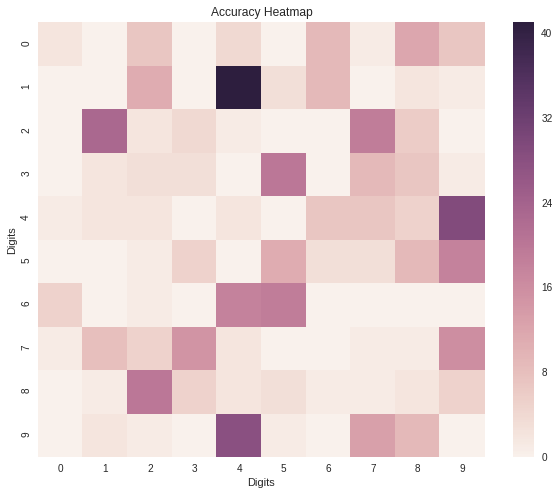

In [0]:
y_test_label = np.argmax(y_test, axis=1)

# y_dnn_pred_label = np.argmax(y_dnn_pred, axis = 1)
# y_dnn_pred_label = np.argmax(y_fgsm_pred, axis = 1)
# y_dnn_pred_label = np.argmax(y_bim_pred, axis = 1)
y_dnn_pred_label = np.argmax(y_mim_pred, axis = 1)




display_classification_results(y_test_label, y_dnn_pred_label)

### Heatmap plots of accuracy of the deep knn predictions

In [0]:
# Below are Predictions from DKNN

# predTest
# predFGSM
# predBIM
# predMIM

Test accuracy: 9.40%
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.17      0.25        42
           1       0.06      0.03      0.04        67
           2       0.08      0.07      0.08        55
           3       0.09      0.07      0.08        45
           4       0.03      0.05      0.04        55
           5       0.22      0.26      0.24        50
           6       0.00      0.00      0.00        43
           7       0.19      0.27      0.22        49
           8       0.04      0.05      0.04        40
           9       0.00      0.00      0.00        54

   micro avg       0.09      0.09      0.09       500
   macro avg       0.12      0.10      0.10       500
weighted avg       0.11      0.09      0.09       500

Confusion Matrix:
 [[ 7  0  5  0  3  0  9  2 11  5]
 [ 0  2 11  0 40  3  9  0  1  1]
 [ 0 20  4  5  0  0  1 19  6  0]
 [ 0  2  3  3  0 20  0  9  7  1]
 [ 1  1  2  0  3  0  7  7  5 29]
 [ 0  0  1  

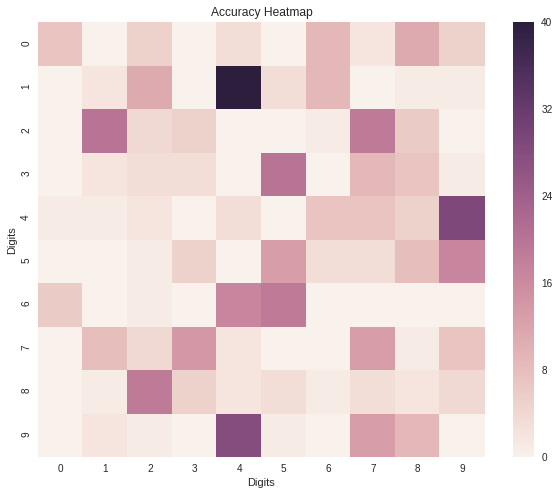

In [0]:
y_test_label = np.argmax(y_test, axis=1)


# display_classification_results(y_test_label, predTest)
# display_classification_results(y_test_label, predFGSM)
# display_classification_results(y_test_label, predBIM)
display_classification_results(y_test_label, predMIM)

## Visualizing output probabilities

In [0]:
import random

In [0]:
y_test_label = np.argmax(y_test, axis=1)

# y_dnn_pred_label = np.argmax(y_dnn_pred, axis = 1)
# y_dnn_pred_label = np.argmax(y_fgsm_pred, axis = 1)
# y_dnn_pred_label = np.argmax(y_bim_pred, axis = 1)
y_dnn_pred_label = np.argmax(y_mim_pred, axis = 1)

In [0]:
def visualizeDigitAndOutputProb(x, y, y_true, title):
  """
  x: one image to plot
  y: output probability of DKNN or onehot encoding
  
  title: string like: "Adversarial example and its output probability"
  """
  
  y = np.asarray(y)
  
  b = np.squeeze(x)
  b = b.astype(np.float32)
  
  y_0 = y.reshape(10)
  
  f, ((ax1, ax2)) = plt.subplots(1, 2)
  f.suptitle( title )
  
  ax1.imshow(b)
  string = "Required="+ str(argmax(y_true))+"    Pred="+str(argmax(y))
  ax1.set_title(string )
  
  ax2.bar(range(10),y_0)
  plt.ylabel("Probabilities")
  plt.xlabel("Labels")
  plt.gca().set_xticks(range(10))
  
 

### Neural Net Output

In [0]:
# Below are output probabilities from just the DeepNet2() neural network:

# y_dnn_pred
# y_fgsm_pred
# y_bim_pred
# y_mim_pred

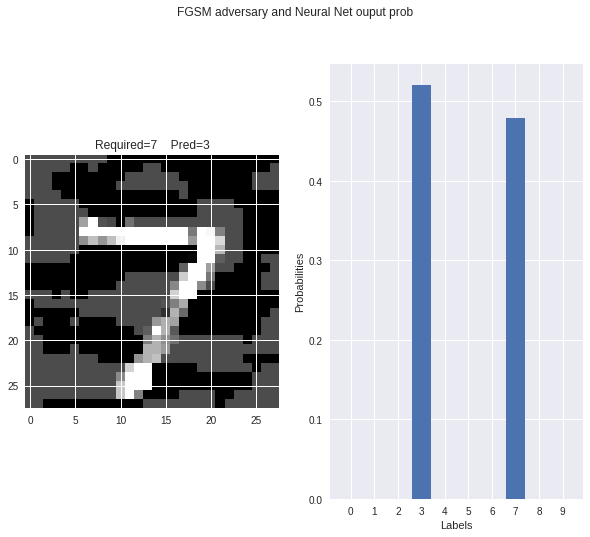

In [0]:
x = x_adv_FGSM[0]
y = y_fgsm_pred[0]
y_true = y_test[0]

visualizeDigitAndOutputProb(x, y, y_true, title = "FGSM adversary and Neural Net ouput prob")

### DKNN output

In [0]:
# In order to get output probabilities, I changed the metrics function:

import numpy as np
from numpy import argmax
def metrics(closest_labels_found, A):
    
    alpha_z_j = []
    alpha_z_j_2 = []
    p_j_z = []
    p_j_z_2 = []
    prediction = []
    credibility = []
    confidence = []
    
    for z in range(len(closest_labels_found)):
        a = np.array(closest_labels_found[z])
        b = a.reshape(a.shape[0]*a.shape[1])
        #print(b)
        alpha_z_j = []
        p_j_z = []
        for label in range(10):     
            c = np.full((a.shape[0]*a.shape[1]), label)
            d = (b != c).sum()          #non_conformity
            alpha_z_j.append(d)         

            #number of values in A which are greater than alpha_z_j- whichh is d here
            e =  np.full((len(A)), d)    
            f = (A >= d).sum()
            g = f*(1/len(A))
            p_j_z.append(g)

        prediction.append(argmax(p_j_z))
        credibility.append(max(p_j_z))
        
        h = p_j_z[:]
        del h[argmax(h)]   
        confidence.append(1 - max(h)) 
        
        #To get something similar to ouput probabilities
#         maximum = max(p_j_z)
#         p_j_z =  [i/maximum for i in p_j_z]
        
        alpha_z_j_2.append(alpha_z_j)   ###for other find this
        p_j_z_2.append(p_j_z) ##################       return this as well
        
    return(prediction, credibility, confidence, p_j_z_2)

In [0]:
predFGSM,credFGSM,confFGSM,outputProbFGSM = metrics(closestNeighbors_ForAllFGSMInputs, A)

In [0]:
# Below are output probabilities from DKNN

# outputProbBIM
# outputProbFGSM
# outputProbMIM
# outputProbTest

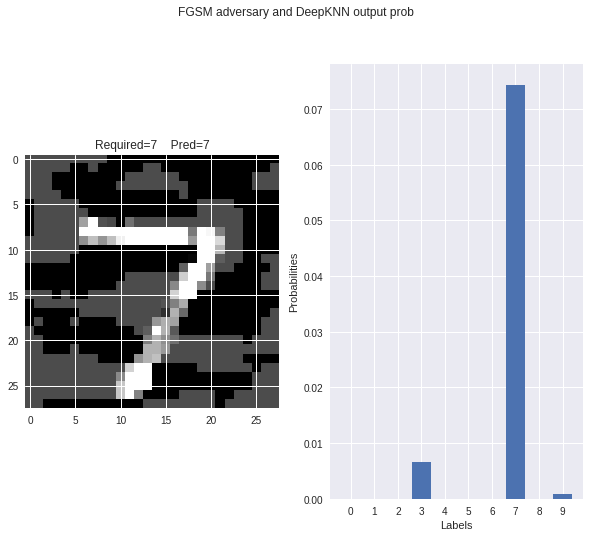

In [0]:
x = x_adv_FGSM[0]
y = outputProbFGSM[0]
y_true = y_test[0]


# Look at the probabilities on the y axis. They do not sum up to 1
visualizeDigitAndOutputProb(x, y, y_true, title = "FGSM adversary and DeepKNN output prob")

In [0]:
# In order to get output probabilities, I changed the metrics function:

import numpy as np
from numpy import argmax
def metrics(closest_labels_found, A):
    
    alpha_z_j = []
    alpha_z_j_2 = []
    p_j_z = []
    p_j_z_2 = []
    prediction = []
    credibility = []
    confidence = []
    
    for z in range(len(closest_labels_found)):
        a = np.array(closest_labels_found[z])
        b = a.reshape(a.shape[0]*a.shape[1])
        #print(b)
        alpha_z_j = []
        p_j_z = []
        for label in range(10):     
            c = np.full((a.shape[0]*a.shape[1]), label)
            d = (b != c).sum()          #non_conformity
            alpha_z_j.append(d)         

            #number of values in A which are greater than alpha_z_j- whichh is d here
            e =  np.full((len(A)), d)    
            f = (A >= d).sum()
            g = f*(1/len(A))
            p_j_z.append(g)

        prediction.append(argmax(p_j_z))
        credibility.append(max(p_j_z))
        
        h = p_j_z[:]
        del h[argmax(h)]   
        confidence.append(1 - max(h)) 
        
        #To get something similar to ouput probabilities
        maximum = max(p_j_z)
        p_j_z =  [i/maximum for i in p_j_z]
        
        alpha_z_j_2.append(alpha_z_j)   ###for other find this
        p_j_z_2.append(p_j_z) ##################       return this as well
        
    return(prediction, credibility, confidence, p_j_z_2)

In [0]:
predFGSM,credFGSM,confFGSM,outputProbFGSM = metrics(closestNeighbors_ForAllFGSMInputs, A)

In [0]:
# Below are output probabilities from DKNN

# outputProbBIM
# outputProbFGSM
# outputProbMIM
# outputProbTest

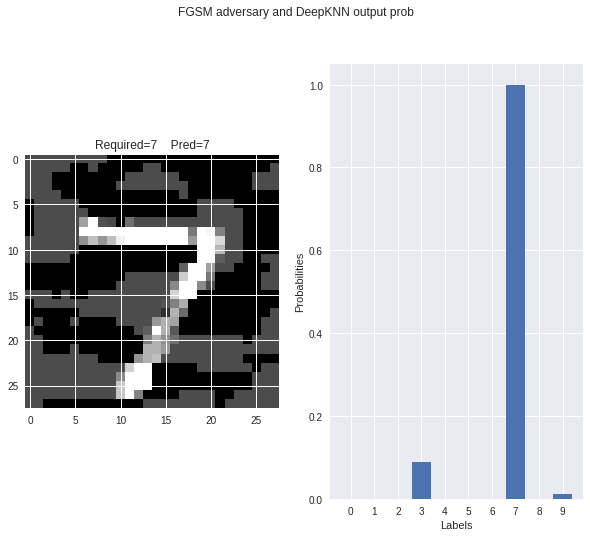

In [0]:
x = x_adv_FGSM[0]
y = outputProbFGSM[0]
y_true = y_test[0]


# Look at the probabilities on the y axis. Now the sum of probabilities is closer to 1 but goes above 1.
visualizeDigitAndOutputProb(x, y, y_true, title = "FGSM adversary and DeepKNN output prob")

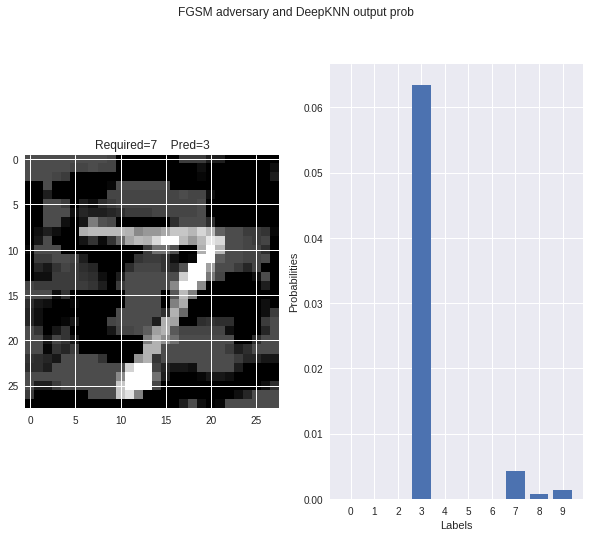

In [0]:
x = x_adv_MIM[0]
y = outputProbMIM[0]
y_true = y_test[0]


# Look at the probabilities on the y axis. They do not sum up to 1
visualizeDigitAndOutputProb(x, y, y_true, title = "FGSM adversary and DeepKNN output prob")

In [0]:
# Below are output probabilities from just the DeepNet2() neural network:

# y_dnn_pred
# y_fgsm_pred
# y_bim_pred
# y_mim_pred

In [0]:
# output probabilities from dknn algorithm

# outputProbTest
# outputProbFGSM
# outputProbBIM
# outputProbMIM

## Barplot of performance comparison on different adversarial attacks

In [0]:
predTest,credTest,confTest, outputProbTest = metrics(closestNeighbors_ForAllTestInputs, A)

In [0]:
def credibility_morethan_50(credList, predList, y_test, name ,verbose = 1):
  count = 0
  accuracy = 0
  for i in range(len(credList)):
    if credList[i] >= 0.5:
      count += 1
      if predList[i] == np.argmax(y_test[i]):
        accuracy += 1
  
  if verbose >= 1:
    print("Credibility above 50% for ",count," number of "+name+" samples out of ",num_test," number of total test samples.")  
    if verbose == 2:
      print("Accurate predictions for the credible samples is ", accuracy, "out of ",num_test," number of total test samples.")
      
  return (count, accuracy)

In [0]:
# The numbers below seem to low for my subset data.

countTest, credible_and_accurate_Test = credibility_morethan_50(credTest, predTest, y_test, "TEST", verbose = 2)

Credibility above 50% for  184  number of TEST samples out of  500  number of total test samples.
Accurate predictions for the credible samples is  184 out of  500  number of total test samples.


In [0]:
# number of classifications by the dknn with credibility >= 0.5 

counts = [
          countBIM,
          countMIM,
          countFGSM,
          countTest,
        ]

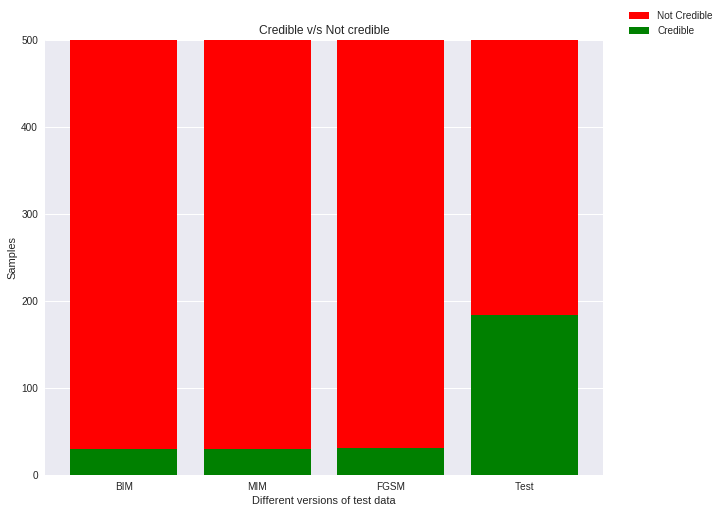

In [0]:
fig = plt.figure()
ax = plt.subplot(111)

p1 = plt.bar(range(4), [num_test for i in range(4)], color = 'red')
p2 = plt.bar(range(4), counts, color = 'green')



plt.ylabel('Samples')
plt.xlabel('Different versions of test data')
plt.title('Credible v/s Not credible')
plt.xticks(range(4), ('BIM', 'MIM', 'FGSM', 'Test'))
plt.ylim(bottom=0 , top=500) 

legend = plt.legend((p1[0], p2[0]), ('Not Credible', 'Credible') , loc=(1.04,1))
  
frame = legend.get_frame()
frame.set_facecolor('white')

plt.show()
